# Variance and PPP: Global Means


In [2]:
# Importing packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import nc_time_axis
from dask.diagnostics import ProgressBar
import re

In [2]:
# minor helper method - returns the ppname for a particular driver
def pp(driver):
    if driver=='tos' or driver=='sos' or driver=='MLD_003':
        return 'ocean_month'
    elif re.search('intpp*',driver):
        return 'ocean_cobalt_omip_2d'
    elif driver=='chlos':
        return 'ocean_cobalt_omip_sfc'

In [3]:
gridpath = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/GRID/ocean.static.nc')
grid = xr.open_dataset(gridpath)

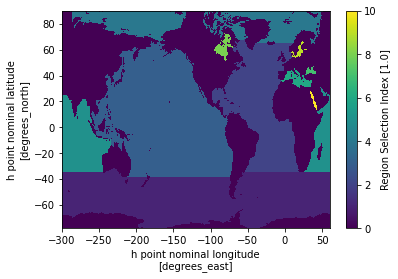

In [4]:
grid.basin.plot()
# use xarray where to grab stuff in particular basin
#where grid geolat > 0 --> gives north atlantic, ( can subset the basins more )

In [21]:
grid.basin

<xarray.DataArray 'basin' (yh: 576, xh: 720)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
Attributes:
    long_name:      Region Selection Index
    standard_name:  region
    units:          1.0
    interp_method:  none
    flag_values:    0 1 2 3 4 5 6 7 8 9 10
    flag_meanings:  global_land southern_ocean atlantic_ocean pacific_ocean a...

### Getting the time-series global mean from netcdf files for each driver and computing the monthly variances

In [5]:
tos_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/tos_mean.nc')
sos_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/sos_mean.nc')
mld_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/MLD_003_mean.nc')
npp_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/npp_mean.nc')


In [6]:
chlos_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/chlos_mean.nc')


In [7]:
npp_month_var = (npp_mean['intpp'].groupby('time.month').std())**2

In [8]:
chlos_month_var = (chlos_mean['chlos'].groupby('time.month').std())**2

In [9]:
tos_month_var = (tos_mean['tos'].groupby('time.month').std())**2

In [10]:
sos_month_var = (sos_mean['sos'].groupby('time.month').std())**2

In [11]:
mld_month_var = (mld_mean['MLD_003'].groupby('time.month')).std()**2

### Methods to compute 1. the variance for a particular ensemble start year, and 2. average the variances over all ensemble start years

In [4]:
# returns the variance for a particular ensemble start year
def ens_var(start_year, driver_global, driver,basin=0):
    # create a list of xarrays of control + ensemble data to be concatenated
    members = [*range(10)]
    ppname = pp(driver)
    
    # handle the control separately
    end = '0' + str(int(start_year) + 9)
    ctrl_slice = driver_global.sel(time=slice(start_year+'-01-16',end+'-12-16'))
    members[0] = ctrl_slice
    
    # loop through all 9 ensemble members
    for member in range(1,10):
        folder = 'ESM4_piControl_D-ensemble-' + start_year + '0101-0' + str(member)
        path = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/'
                +folder+'/gfdl.ncrc4-intel18-prod-openmp/pp/'+ppname+'/ts/monthly/5yr/'+ppname+'.*'+driver+'.nc')
        ens_mem = xr.open_mfdataset(path)
        if basin > 0:
            ens_mem = ens_mem.where(grid['basin']==basin)
        ens_mem = (ens_mem[driver].weighted(grid['areacello']).mean(['xh','yh'])).to_dataset()
        members[member] = ens_mem
        
    # combine all ensemble members and control into one xarray
    all_members = xr.concat(members,dim='members')
    
    # compute the variance
    variance = (all_members.std(dim='members')) ** 2
    
    return variance
    


In [5]:
STARTS = ['0123','0161','0185','0208','0230','0269','0300','0326','0359','0381']
def avg_ens_var(driver_global, driver, basin=0):
    # initialize total to be stddev of first ensemble - year '0123'
    
    ensembles = [*range(10)]
    first = ens_var(STARTS[0],driver_global,driver,basin)
    timei = first.time
    ensembles[0] = first
    
    for ens in range(1,10):
        time_adjusted = ens_var(STARTS[ens],driver_global,driver,basin).assign_coords(time=timei)
        ensembles[ens] = time_adjusted
    
    total = xr.concat(ensembles,dim='ensemble')
    avg = total.mean(dim='ensemble')
    
    return avg


### Running these methods on all of our driver variables:

In [14]:
tos_var = avg_ens_var(tos_mean,'tos')
with ProgressBar():
    tos_var = tos_var.compute()

[########################################] | 100% Completed | 53.7s


In [15]:
sos_var = avg_ens_var(sos_mean,'sos')
with ProgressBar():
    sos_var = sos_var.compute()
    
mld_var = avg_ens_var(mld_mean,'MLD_003')
with ProgressBar():
    mld_var = mld_var.compute()

[########################################] | 100% Completed | 51.5s
[########################################] | 100% Completed | 49.5s


In [16]:
npp_var = avg_ens_var(npp_mean,'intpp')
with ProgressBar():
    npp_var = npp_var.compute()

[########################################] | 100% Completed | 49.7s


In [17]:
chlos_var = avg_ens_var(chlos_mean,'chlos')
with ProgressBar():
    chlos_var = chlos_var.compute()

[########################################] | 100% Completed | 52.3s


### Plotting the PPP for all our driver variables

In [53]:
def plot_ppp(driver_month_var, driver_var,driver):
    driver_var_array = driver_month_var.to_numpy()
    repeated = np.tile(driver_var_array, 10)
    
    driver_ens_array = driver_var.to_array().to_numpy()
    ratio = driver_ens_array / repeated
    ppp = np.ones(len(ratio)) - ratio
    plt.plot(ppp.squeeze())
    plt.title('PPP of '+driver)
    plt.xlabel('Time (Months after Initialization)')
    plt.ylabel('PPP')
    return ppp.squeeze()


In [54]:
ppp_tos = plot_ppp(tos_month_var,tos_var,'tos')

NameError: name 'tos_month_var' is not defined

In [55]:
ppp_sos = plot_ppp(sos_month_var,sos_var,'sos')

NameError: name 'sos_month_var' is not defined

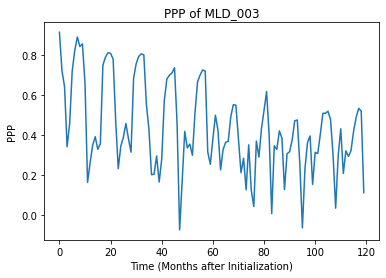

In [21]:
ppp_mld = plot_ppp(mld_month_var,mld_var,'MLD_003')

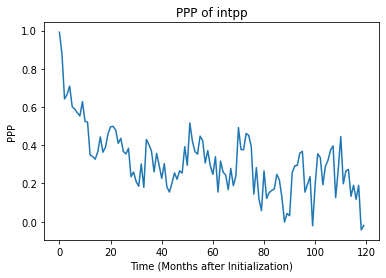

In [22]:
ppp_npp = plot_ppp(npp_month_var,npp_var,'intpp')

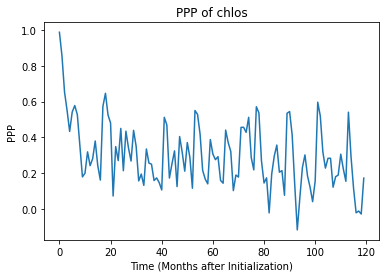

In [23]:
ppp_chlos = plot_ppp(chlos_month_var,chlos_var,'chlos')


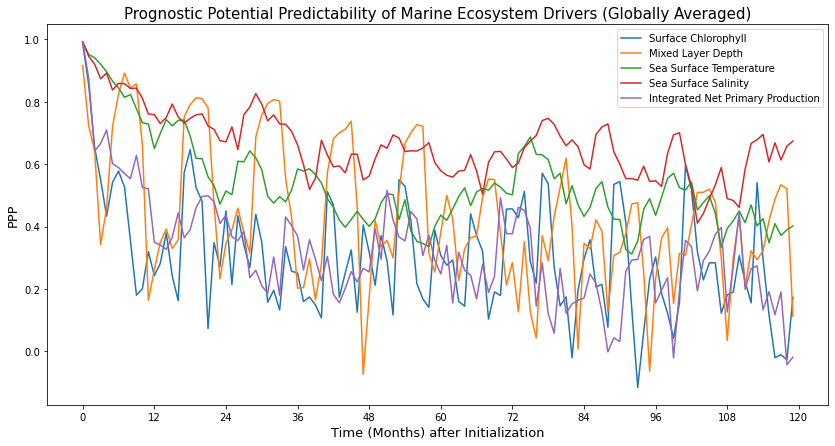

In [24]:
fig,ax = plt.subplots(1,1,figsize=(14,7))
ax.set_xticks([0,12,24,36,48,60,72,84,96,108,120])
ax.plot(ppp_chlos,label='Surface Chlorophyll')
ax.plot(ppp_mld,label='Mixed Layer Depth')
ax.plot(ppp_tos,label='Sea Surface Temperature')
ax.plot(ppp_sos,label='Sea Surface Salinity')
ax.plot(ppp_npp,label='Integrated Net Primary Production')
plt.legend(bbox_to_anchor=(1,1))
plt.title('Prognostic Potential Predictability of Marine Ecosystem Drivers (Globally Averaged)',fontsize=15)
plt.xlabel('Time (Months) after Initialization',fontsize=13)
plt.ylabel('PPP',fontsize=13)
plt.savefig('Prognostic Potential Predictability of Marine Ecosystem Drivers (Globally Averaged)')

# Packaged into one function:
Now, I'll put all of this together into one function that takes as input just the string driver and produces a plot of the PPP (will be useful later when adding more variables into the mix):

In [7]:
def driver_ppp_plot(driver):
    driver_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/'+driver+'_mean.nc')
    driver_month_var = (driver_mean[driver].groupby('time.month').std())**2
    
    driver_var = avg_ens_var(driver_mean,driver)
    
    with ProgressBar():
        driver_var = driver_var.compute()
    
    return plot_ppp(driver_month_var,driver_var,driver)
#     driver_ppp = get_ppp(driver_var,driver_month_var)
    
#     # Plotting
#     plt.plot(driver_ppp, color='r',mfc='pink')
#     plt.title('PPP of ' + driver_name)
#     plt.xlabel('Time (Months after Initialization)')
#     plt.ylabel('PPP')

In [10]:
pico = driver_ppp_plot('intpppico')


KeyboardInterrupt: 

In [ ]:
diaz = driver_ppp_plot('intppdiaz')

In [ ]:
diat = driver_ppp_plot('intppdiat')

In [ ]:
misc = driver_ppp_plot('intppmisc')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(14,7))
ax.set_xticks([0,12,24,36,48,60,72,84,96,108,120])
ax.plot(diat,label='intppdiat')
ax.plot(misc,label='intppmisc')
ax.plot(diaz,label='intppdiaz')
ax.plot(pico='intpppico')
ax.plot(ppp_npp,label='Integrated Net Primary Production')
plt.legend(bbox_to_anchor=(1,1))
plt.title('Prognostic Potential Predictability of Integrated Net Primary Production',fontsize=15)
plt.xlabel('Time (Months) after Initialization',fontsize=13)
plt.ylabel('PPP',fontsize=13)
plt.savefig('Prognostic Potential Predictability of Integrated Net Primary Production')

# Basins 

In [8]:
BASINS = ['global_land', 'southern_ocean', 'atlantic_ocean', 'pacific_ocean', 'arctic_ocean', 'indian_ocean', 'mediterranean_sea', 'black_sea', 'hudson_bay', 'baltic_sea', 'red_sea']

def basin_ppp_plot(driver,basin):
    driver_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Basins_Mean/'+driver+'_'+BASINS[basin]+'_mean.nc')
    driver_month_var = (driver_mean[driver].groupby('time.month').std())**2
    
    driver_var = avg_ens_var(driver_mean,driver,basin)
    with ProgressBar():
        driver_var = driver_var.compute()
    
    return plot_ppp(driver_month_var,driver_var,driver)

In [25]:
tos_basins = [*range(len(BASINS))]
for b in range(len(BASINS)):
    tos_basins[b] = basin_ppp_plot('tos',b)


[########################################] | 100% Completed |  1min  3.4s
[########################################] | 100% Completed |  1min  4.7s
[########################################] | 100% Completed |  1min 10.8s
[########################################] | 100% Completed |  1min  4.1s
[##################################      ] | 86% Completed | 55.4s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NameError: name 'ppp_tos' is not defined

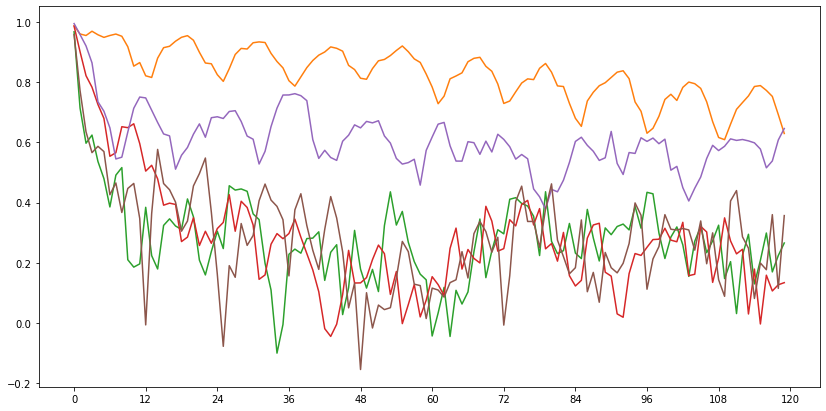

In [52]:
fig,ax = plt.subplots(1,1,figsize=(14,7))
ax.set_xticks([0,12,24,36,48,60,72,84,96,108,120])
for b in range(len(tos_basins)):
    if b < 6:
        ax.plot(tos_basins[b],label=BASINS[b])
ax.plot(ppp_tos,linewidth=2,label=global_mean)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Prognostic Potential Predictability of Sea Surface Temperature',fontsize=15)
plt.xlabel('Time (Months) after Initialization',fontsize=13)
plt.ylabel('PPP',fontsize=13)
plt.savefig('Basins-Prognostic Potential Predictability of NPP')

[########################################] | 100% Completed | 49.2s
[########################################] | 100% Completed | 56.3s
[########################################] | 100% Completed | 56.7s
[########################################] | 100% Completed | 56.9s
[########################################] | 100% Completed | 57.5s
[########################################] | 100% Completed | 57.0s
[########################################] | 100% Completed | 55.7s
[########################################] | 100% Completed | 56.2s
[########################################] | 100% Completed | 55.9s
[########################################] | 100% Completed | 58.7s
[########################################] | 100% Completed | 57.1s


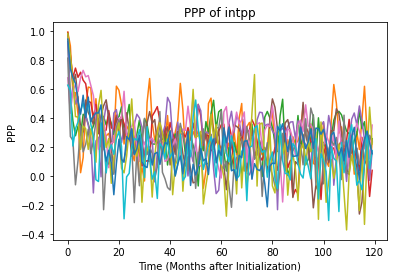

In [9]:
npp_basins = [*range(len(BASINS))]
for b in range(len(BASINS)):
    npp_basins[b] = basin_ppp_plot('intpp',b)

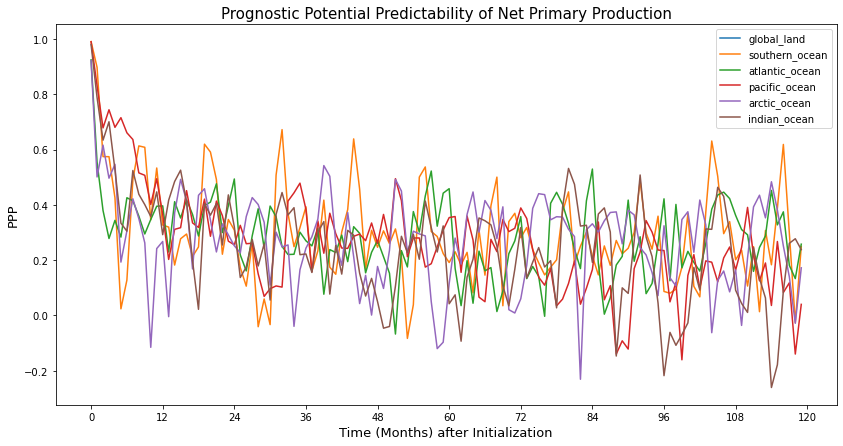

In [29]:
fig,ax = plt.subplots(1,1,figsize=(14,7))
ax.set_xticks([0,12,24,36,48,60,72,84,96,108,120])
for b in range(len(npp_basins)):
    if b < 6:
        ax.plot(npp_basins[b],label=BASINS[b])
plt.legend(bbox_to_anchor=(1,1))
plt.title('Prognostic Potential Predictability of Net Primary Production',fontsize=15)
plt.xlabel('Time (Months) after Initialization',fontsize=13)
plt.ylabel('PPP',fontsize=13)
plt.savefig('Basins-Prognostic Potential Predictability of NPP')

[########################################] | 100% Completed | 49.9s
[########################################] | 100% Completed | 55.9s
[########################################] | 100% Completed | 57.1s
[########################################] | 100% Completed | 56.7s
[########################################] | 100% Completed | 56.7s
[########################################] | 100% Completed | 58.0s
[########################################] | 100% Completed | 55.8s
[########################################] | 100% Completed | 59.7s
[########################################] | 100% Completed | 56.4s
[########################################] | 100% Completed | 58.6s
[########################################] | 100% Completed | 56.3s


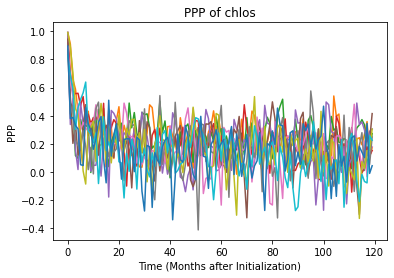

In [18]:
chlos_basins = [*range(len(BASINS))]
for b in range(len(BASINS)):
    chlos_basins[b] = basin_ppp_plot('chlos',b)

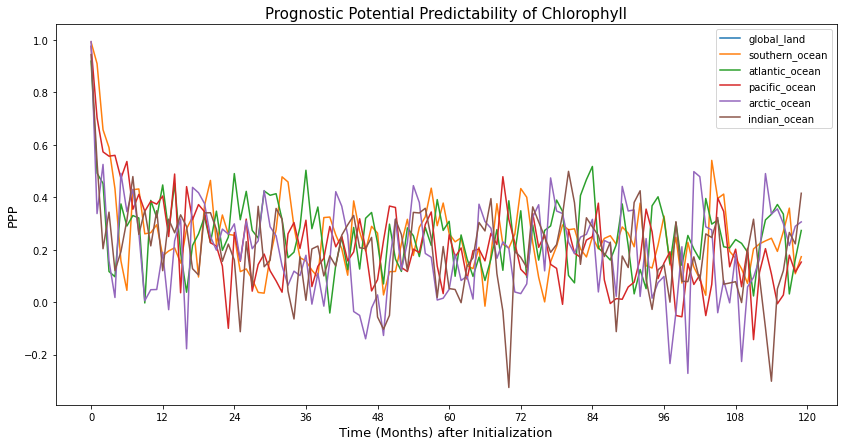

In [30]:
fig,ax = plt.subplots(1,1,figsize=(14,7))
ax.set_xticks([0,12,24,36,48,60,72,84,96,108,120])
for b in range(len(chlos_basins)):
    if b < 6:
        ax.plot(chlos_basins[b],label=BASINS[b])
ax.plot(npp_)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Prognostic Potential Predictability of Chlorophyll',fontsize=15)
plt.xlabel('Time (Months) after Initialization',fontsize=13)
plt.ylabel('PPP',fontsize=13)
plt.savefig('Basins-Prognostic Potential Predictability of Chlorophyll')

[########################################] | 100% Completed | 51.8s
[########################################] | 100% Completed | 57.9s
[########################################] | 100% Completed | 58.2s
[########################################] | 100% Completed | 58.4s
[########################################] | 100% Completed | 58.2s
[########################################] | 100% Completed | 58.0s
[########################################] | 100% Completed | 57.4s
[########################################] | 100% Completed | 57.4s
[########################################] | 100% Completed | 57.2s
[########################################] | 100% Completed | 56.8s


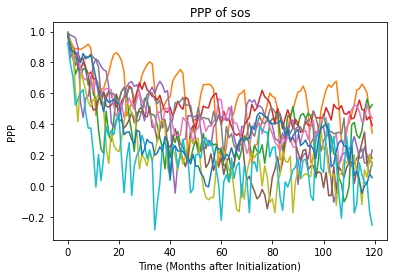

In [23]:
sos_basins = [*range(len(BASINS))]
for b in range(len(BASINS)):
    sos_basins[b] = basin_ppp_plot('sos',b)

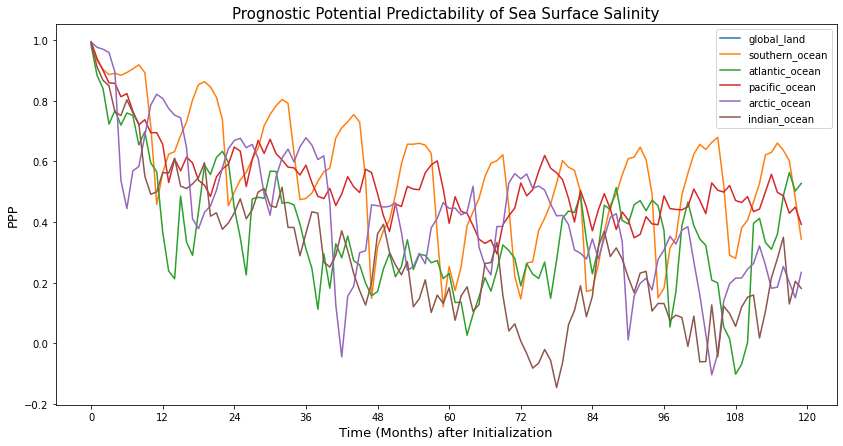

In [31]:
fig,ax = plt.subplots(1,1,figsize=(14,7))
ax.set_xticks([0,12,24,36,48,60,72,84,96,108,120])
for b in range(len(sos_basins)):
    if b < 6:
        ax.plot(sos_basins[b],label=BASINS[b])
plt.legend(bbox_to_anchor=(1,1))
plt.title('Prognostic Potential Predictability of Sea Surface Salinity',fontsize=15)
plt.xlabel('Time (Months) after Initialization',fontsize=13)
plt.ylabel('PPP',fontsize=13)
plt.savefig('Basins-Prognostic Potential Predictability of Salinity')

[########################################] | 100% Completed | 50.0s
[########################################] | 100% Completed | 56.5s
[########################################] | 100% Completed | 57.3s
[########################################] | 100% Completed | 57.2s
[########################################] | 100% Completed | 57.2s
[########################################] | 100% Completed | 56.3s
[########################################] | 100% Completed | 56.0s
[########################################] | 100% Completed | 56.0s
[########################################] | 100% Completed | 56.1s
[########################################] | 100% Completed | 56.4s
[########################################] | 100% Completed | 56.3s


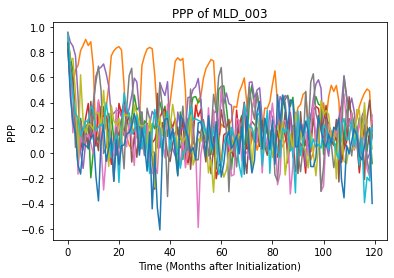

In [16]:
mld_basins = [*range(len(BASINS))]
for b in range(len(BASINS)):
    mld_basins[b] = basin_ppp_plot('MLD_003',b)


In [39]:
dsnew = xr.Dataset(coords={'time':np.arange(0,120)})
for b in range(11):
    dsnew[BASINS[b]] = xr.DataArray(mld_basins[b],dims=['time'])

In [46]:
dsnew

<xarray.Dataset>
Dimensions:            (time: 120)
Coordinates:
  * time               (time) int64 0 1 2 3 4 5 6 ... 114 115 116 117 118 119
Data variables:
    global_land        (time) float64 nan nan nan nan nan ... nan nan nan nan
    southern_ocean     (time) float64 0.87 0.5407 0.5432 ... 0.4902 0.1159
    atlantic_ocean     (time) float64 0.9249 0.7604 0.6554 ... 0.1892 -0.08322
    pacific_ocean      (time) float64 0.9254 0.7103 0.5508 ... 0.06907 0.1453
    arctic_ocean       (time) float64 0.9582 0.8794 0.8483 ... -0.003931 0.2568
    indian_ocean       (time) float64 0.8248 0.5305 0.2239 ... 0.273 0.42 0.181
    mediterranean_sea  (time) float64 0.9353 0.6473 0.1611 ... -0.1873 0.3025
    black_sea          (time) float64 0.9521 0.658 0.494 ... -0.1571 0.223
    hudson_bay         (time) float64 0.9283 0.7303 0.7515 ... 0.1668 0.03364
    baltic_sea         (time) float64 0.9411 0.6624 0.4617 ... -0.2205 0.2004
    red_sea            (time) float64 0.8731 0.4522 0.2432 ... 0.2019 -0.3991

In [43]:
dsnew.to_netcdf('/home/saumyam/basin')

In [44]:
dsmld = xr.open_dataset('/home/saumyam/basin')

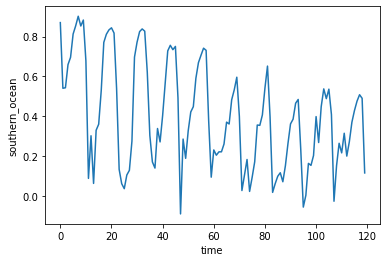

In [47]:
dsmld['southern_ocean'].plot()

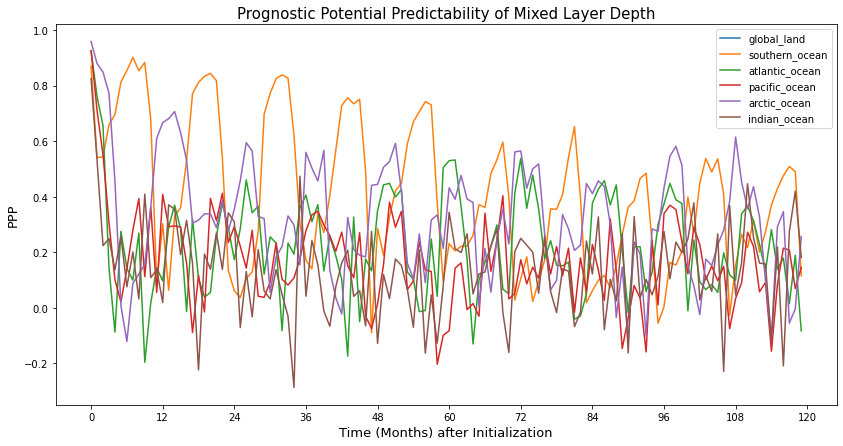

In [32]:
fig,ax = plt.subplots(1,1,figsize=(14,7))
ax.set_xticks([0,12,24,36,48,60,72,84,96,108,120])
for b in range(len(mld_basins)):
    if b < 6:
        ax.plot(mld_basins[b],label=BASINS[b])
plt.legend(bbox_to_anchor=(1,1))
plt.title('Prognostic Potential Predictability of Mixed Layer Depth',fontsize=15)
plt.xlabel('Time (Months) after Initialization',fontsize=13)
plt.ylabel('PPP',fontsize=13)
plt.savefig('Basins-Prognostic Potential Predictability of MLD')

[########################################] | 100% Completed | 57.3s


array([0.9887037 , 0.96142838, 0.95630377, 0.97051485, 0.95875327,
       0.95005582, 0.95634757, 0.96115218, 0.95374583, 0.91893029,
       0.85432318, 0.86615247, 0.82207102, 0.8165921 , 0.88088684,
       0.91574557, 0.92044417, 0.9373499 , 0.95032471, 0.95580331,
       0.94052469, 0.90044525, 0.86468567, 0.86216533, 0.82586016,
       0.80359156, 0.84572036, 0.8931152 , 0.91335425, 0.91130897,
       0.93216623, 0.93500409, 0.9329482 , 0.89677904, 0.86973178,
       0.84850986, 0.8058008 , 0.78767267, 0.81848127, 0.84935015,
       0.87310194, 0.89085701, 0.90142794, 0.91833492, 0.91369343,
       0.90414488, 0.85678334, 0.84287826, 0.81396123, 0.81059441,
       0.8461048 , 0.87201425, 0.87659007, 0.88954625, 0.90642209,
       0.92145761, 0.90240267, 0.87844576, 0.86663526, 0.82797689,
       0.78469096, 0.72908586, 0.75440721, 0.81214334, 0.82151707,
       0.83198822, 0.8689034 , 0.88034845, 0.88365364, 0.85372739,
       0.83715436, 0.79473776, 0.73001761, 0.73812598, 0.76878

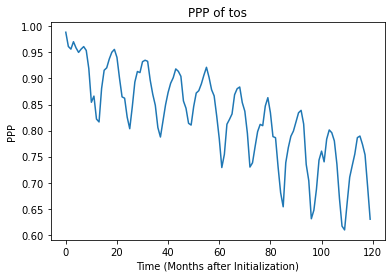

In [17]:
basin_ppp_plot('tos',1)

[########################################] | 100% Completed | 58.2s


array([0.99601273, 0.95938468, 0.92164483, 0.86533795, 0.73565852,
       0.70412503, 0.64884722, 0.5451689 , 0.55109311, 0.63478577,
       0.71398549, 0.75135082, 0.74846044, 0.70757376, 0.66668323,
       0.62850683, 0.62202732, 0.51118652, 0.55751116, 0.58350159,
       0.6276594 , 0.66193298, 0.61748816, 0.68252004, 0.6857202 ,
       0.67992692, 0.70330559, 0.70588998, 0.67000779, 0.62141745,
       0.61094809, 0.52838163, 0.57064023, 0.65286887, 0.71433186,
       0.75803925, 0.75835352, 0.76259527, 0.75590675, 0.73939253,
       0.60949903, 0.54706578, 0.57400369, 0.54999971, 0.54046499,
       0.60423488, 0.62434569, 0.65874404, 0.64870211, 0.67026205,
       0.66538229, 0.67253577, 0.62182087, 0.59805597, 0.54699325,
       0.52810501, 0.53302707, 0.54423673, 0.45803763, 0.57372722,
       0.61820167, 0.66108606, 0.66684239, 0.58899849, 0.53814667,
       0.53800018, 0.60266158, 0.59934512, 0.56064574, 0.60447178,
       0.56846678, 0.62749323, 0.61038487, 0.58587152, 0.54461

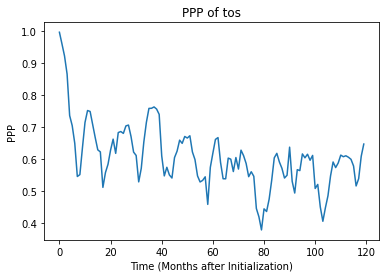

In [18]:
basin_ppp_plot('tos',4)

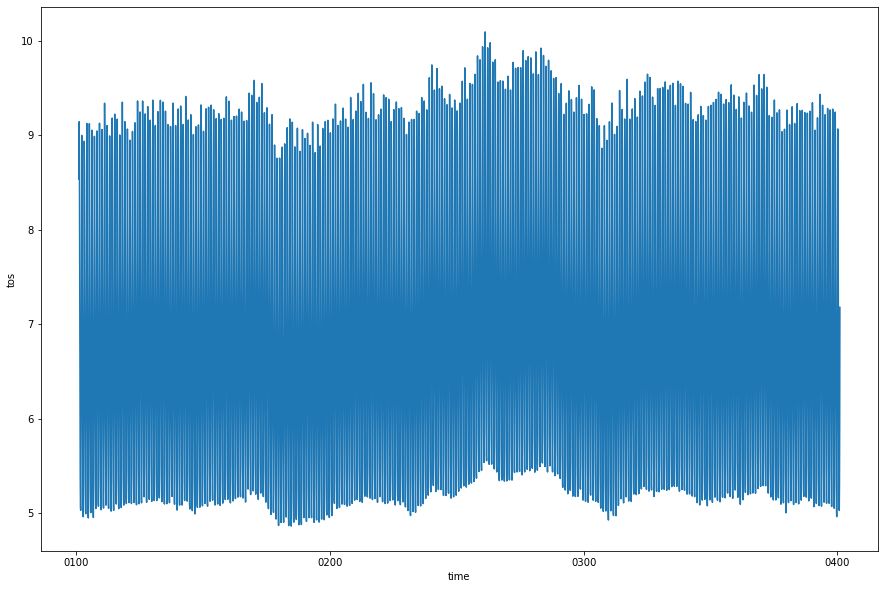

In [10]:
tos_southern = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Basins_Mean/tos_southern_ocean_mean.nc')
tos_southern['tos'].plot(size=10)

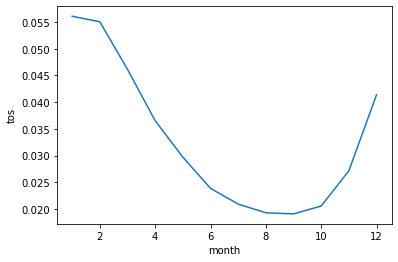

In [11]:
tos_southern_month_var = (tos_southern['tos'].groupby('time.month').std())**2
tos_southern_month_var.plot()

### Saving all these results to files

In [51]:
driver_basins = [tos_basins,sos_basins,mld_basins,npp_basins,chlos_basins]
driver_names = ['tos','sos','mld','npp','chlos']
for i in range(len(driver_basins)):
    dsnew = xr.Dataset(coords={'time':np.arange(0,120)})
    for b in range(11):
        dsnew[BASINS[b]] = xr.DataArray(driver_basins[i][b],dims=['time'])
    dsnew.to_netcdf('/home/saumyam/data_netcdf_files/PPP_By_Basin/'+driver_names[i])

# Scratch Work

In [ ]:
tos_ppp = get_ppp(tos_var,tos_month_var)
sos_ppp = get_ppp(sos_var,sos_month_var)
mld_ppp = get_ppp(mld_var,mld_month_var)
npp_ppp = get_ppp(npp_var,npp_month_var)
chlos_ppp = get_ppp(chlos_var,chlos_month_var)

In [ ]:
# sanity check method
def plot_both_variance(driver_month_var, driver_ens_var,driver):
    driver_var_array = driver_month_var.to_numpy()
    repeated = np.tile(driver_var_array, 10)
    fig,ax = plt.subplots(1,1,figsize=(10,5))
    ax.plot(repeated)
    ax.plot(driver_ens_var[driver],color='r')
    plt.ylabel('Variance in ' + driver)
    plt.xlabel('Month after initialization')
    plt.title("Variance in Control Run (Blue) and Ensemble Runs (Red)")

plot_both_variance(chlos_month_var,chlos_var,'chlos')

In [ ]:
def get_ppp(driver_ens_var, month_var):
    driver_ens_var = driver_ens_var.to_array()
    ppp = [*range(120)]
    for t in range(120):
        ppp[t] = 1 - (driver_ens_var.isel(time=t) / month_var['month'==t%12])
    return ppp
#check out .repeat() for numpy - consider repeating the control mean 

In [ ]:
plt.plot(sos_ppp)
plt.title('PPP of SSS')
plt.xlabel('Time (Months after Initialization)')
plt.ylabel('PPP')
#plt.savefig('PPP of SST, Ensemble Start Year 208')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(repeated)
ax.plot(mld_var['MLD_003'],color='r')
plt.ylabel('Variance in MLD')
plt.xlabel('Month after initialization')
plt.title("Variance in Control Run (Blue) and Ensemble Runs (Red)")

In [ ]:
plt.plot(tos_ppp)
plt.title('PPP of SST')
plt.xlabel('Time (Months after Initialization)')
plt.ylabel('PPP')
#plt.savefig('PPP of SST, Ensemble Start Year 208')